# Cluster-based permutation test

The cluster-based permutation test is a non-parametric test to reveal if two conditions are significantly different. I know that this test can be a bit difficult to wrap your head around. Here are some additional resources that I found helpful:

- [Intro to cluster permutation statistics](https://benediktehinger.de/blog/science/statistics-cluster-permutation-test/)
- [How not to interpret the results](https://www.fieldtriptoolbox.org/faq/how_not_to_interpret_results_from_a_cluster-based_permutation_test/)
- [MNE-tutorial](https://mne.tools/stable/auto_tutorials/stats-sensor-space/75_cluster_ftest_spatiotemporal.html#sphx-glr-auto-tutorials-stats-sensor-space-75-cluster-ftest-spatiotemporal-py)
- [Fieldtrip tutorial (includes a video)]([https://www.fieldtriptoolbox.org/tutorial/cluster_permutation_timelock/](https://www.fieldtriptoolbox.org/tutorial/cluster_permutation_timelock/))
- [The original paper introducing the test](https://pubmed.ncbi.nlm.nih.gov/17517438/)

## Setting up Python
First of all, we need to make sure that we are working in the `env` environment.


1. Run `bash env_to_jupyter.sh` from the `EEG` folder if you have not already done so. This will make sure that the `env` environment is available as a kernel in this notebook.

2. Press `Select Kernel`, then `Jupyter kernel...` and select `env`. If `env` does not show up, press the little refresh symbol!

**Note:** You might have to install the Jupyter extension for VScode to be able to select the kernel.

## Introduction to the cluster-based permutation test


Shoutout to Mina for the following steps to perform the cluster-based permutation test:
1. Set threshold for t-values (contrast) for clustering
2. Compare conditions: get t-values for the contrast (for the difference in the two conditions) for each time-stamp
3. Form cluster out of t-values for the contrast (two conditions) that go beyond the threshold. Sum the t-values of that particular cluster together with all the neighbouring channels (to get the space dimension). Do this for all the data
4. Take the highest t-value sum among all the clusters you identify. Save this number.
5. PERMUTATION: Shuffle the two conditions i.e., making an empirical null distribution
7. Repeat step 2-4 for the new distribution (data that was shuffled) - recommended to repeat this step 10,000). Save the highest t-value sums of the clusters for each run (i.e., you will end up with 10,000 highest t-value sums)
8. Make a distribution of the 10,000 highest t-value sums 
9. If initial highest t-value value (*from step 4*) is outside the distribution (larger or smaller) then you say that you have a significant difference between the two conditions

Luckily, we don't have to do this by hand and we can use one of the `mne-python` functions to do this. However, it is important to understand the steps above to understand the output of the function. 

In [32]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

## Load the data
First, we load in the data and save them in a variable called `all_epochs`, which is a list of `mne.Epochs` objects. You can use the function you defined in the previous notebook!

In [33]:
def load_epochs(data_path: Path, picks: list[str] = ["eeg"], preload: bool = True) -> list[mne.epochs.EpochsFIF]:
    """
    This function loops over files in data_path and loads all files ending with "-epo.fif".

    Parameters
    ----------
    data_path (Path):
        The path to the directory with the epochs to load.

    picks (list[str]): 
        The types of channels to keep. Defaults to ["eeg"].

    preload (bool): 
        Whether to load all the data into memory at once. Defaults to True.

    Returns
    -------
    list[mne.epochs.EpochsFIF]:
        A list of all epochs from the directory.
    """

    epochs = []  # Empty list for storing the epochs

    for f in data_path.iterdir():
        if f.name.endswith("-epo.fif"):  # Check if filename ends with "-epo.fif"
            try:
                tmp_epochs = mne.read_epochs(f, preload=preload)
                tmp_epochs.pick(picks)
                epochs.append(tmp_epochs)  # Append the loaded epochs to the list
            except Exception as e:
                print(f"Error loading {f}: {e}")  # Print an error message if loading fails

    return epochs

In [34]:
# load in the data
data_path = Path("/work/EEG_lab/example_data_stats")
all_epochs = load_epochs(data_path)

Reading /work/EEG_lab/example_data_stats/Group5-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     496.00 ms
        0 CTF compensation matrices available


Not setting metadata
229 matching events found
No baseline correction applied
0 projection items activated
Reading /work/EEG_lab/example_data_stats/Group6-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     496.00 ms
        0 CTF compensation matrices available
Not setting metadata
196 matching events found
No baseline correction applied
0 projection items activated
Reading /work/EEG_lab/example_data_stats/Group1-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     496.00 ms
        0 CTF compensation matrices available
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated


## Extract the data
For the purpose of this example we will be checking if there is a difference between images and words.

In [35]:
cond1 = "Image"
cond2 = "Word"


epochs_cond1 = [epochs[cond1] for epochs in all_epochs] # we can use a list comprehension to extract the trials for each participant
epochs_cond2= [epochs[cond2] for epochs in all_epochs] 

# obtain the data as a 3D matrix and transpose it such that
# the dimensions are as expected for the cluster permutation test:
# n_trials × n_times × n_channels
data_cond1 = [np.transpose(epochs.get_data(copy = True), (0, 2, 1)) for epochs in epochs_cond1]
data_cond2 = [np.transpose(epochs.get_data(copy = True), (0, 2, 1)) for epochs in epochs_cond2]

print(data_cond1[1].shape)
print(data_cond2[1].shape)

(55, 175, 28)
(52, 175, 28)


## Subject level analysis

In [36]:
# extract the epochs for just one subject
x_subj_cond1 = data_cond1[0]
x_subj_cond2 = data_cond2[0]

## Get adjecency matrix
We need to define the adjacency matrix to be able to cluster the data. This is a matrix that defines which channels are neighbours.

In [37]:
info = epochs_cond1[0].info
adjacency, ch_names = mne.channels.find_ch_adjacency(info, ch_type="eeg")

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 28


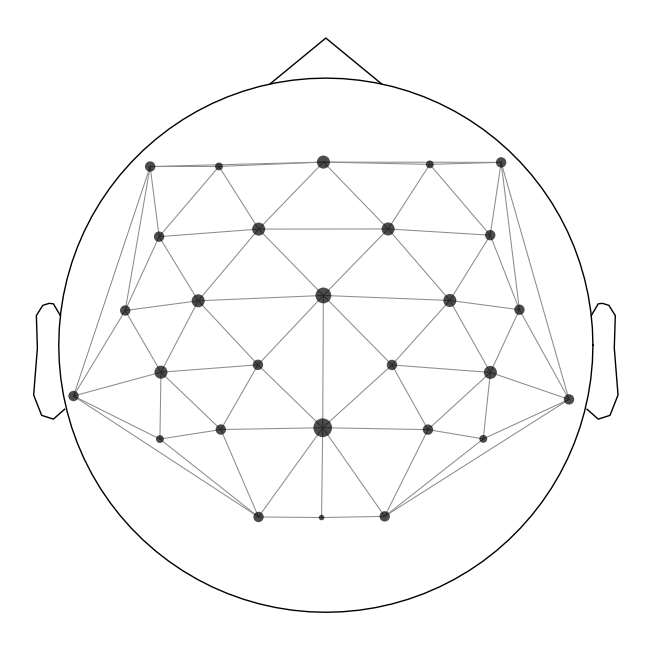

In [38]:
# plot the adjacency
mne.viz.plot_ch_adjacency(info, adjacency, ch_names);

In [39]:
# set family-wise p-value
p_accept = 0.05

# running the permutation test with 1000 permutations and a random seed of 4
cluster_stats = mne.stats.spatio_temporal_cluster_test(
    [x_subj_cond1, x_subj_cond2],
    n_permutations=1000, 
    n_jobs=-1, 
    adjacency=adjacency, 
    seed=4)

# selecting clusters with significant p-values
F_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

Using a threshold of 3.925834
stat_fun(H1): min=6.045412623435875e-07 max=89.69088492643313
Running initial clustering …
Found 35 clusters


/tmp/ipykernel_2735/3220588793.py:5: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  cluster_stats = mne.stats.spatio_temporal_cluster_test(


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

## Plot the clusters

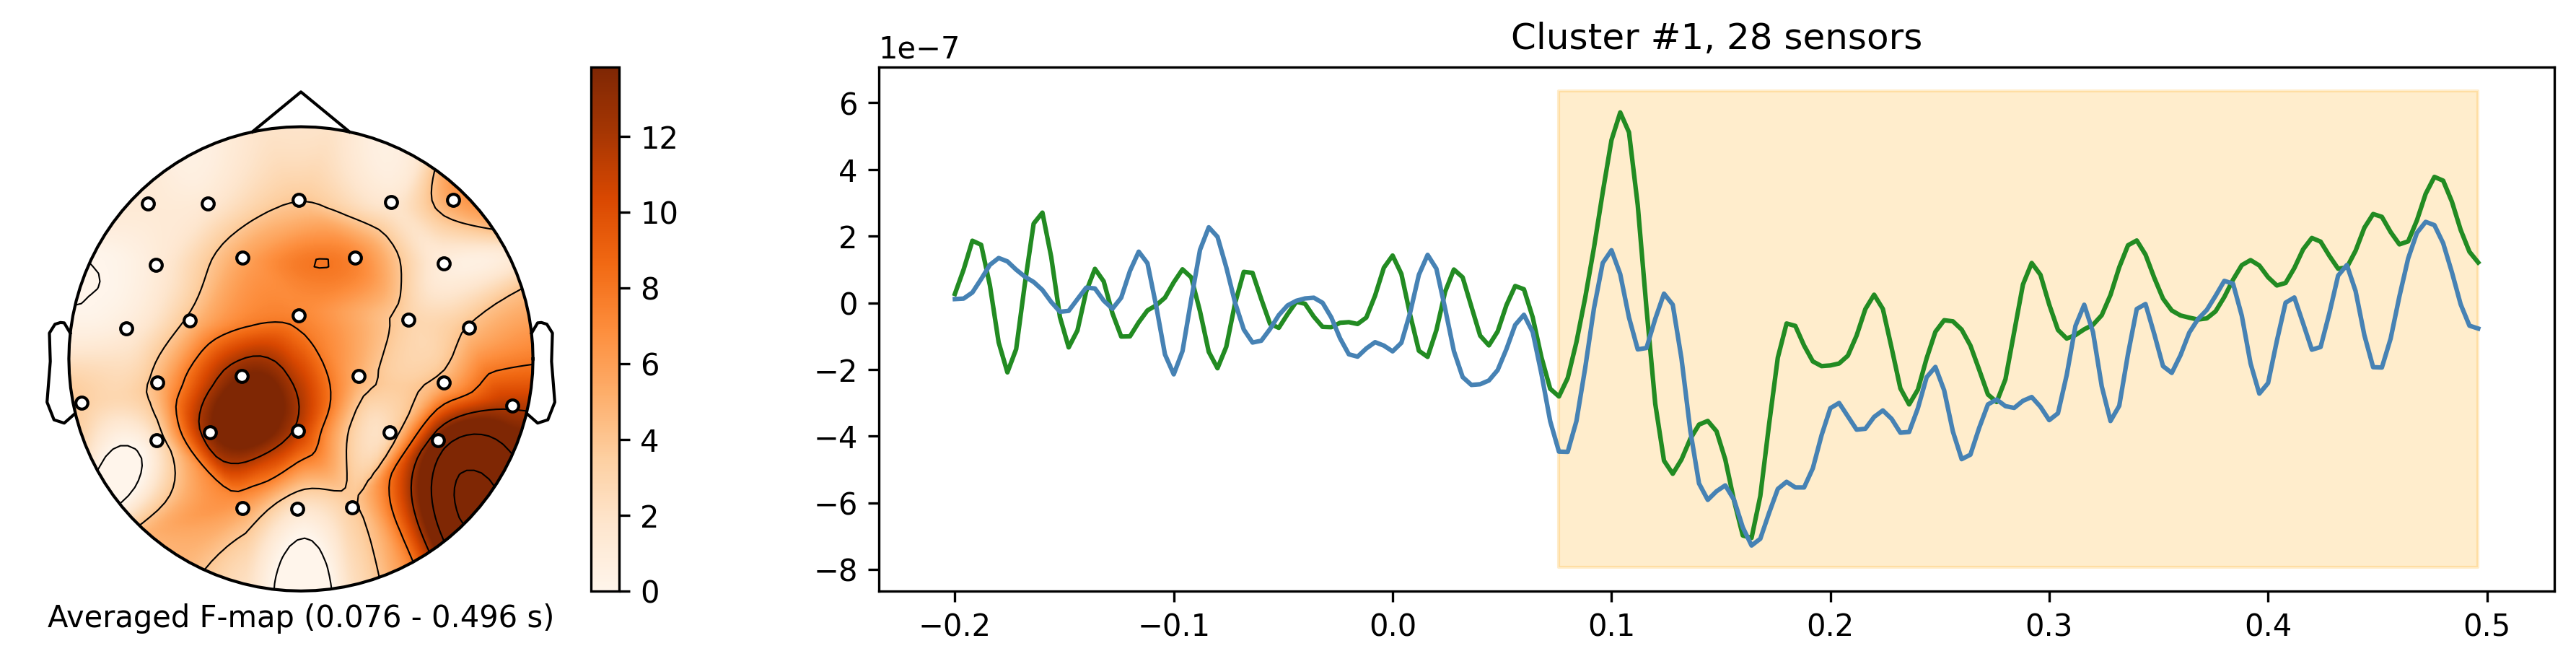

In [40]:
# configuration of variables for visualisation
colors = {"cond1": "forestgreen", "cond2": 'steelblue'}

if len(good_cluster_inds) == 0:
    print('No significant clusters found')

else:
    # looping over clusters
    for i_clu, clu_idx in enumerate(good_cluster_inds):
        # unpacking cluster information
        time_inds, space_inds = np.squeeze(clusters[clu_idx])
        ch_inds = np.unique(space_inds)
        time_inds = np.unique(time_inds)

        # topography for stats
        f_map = F_obs[time_inds, ...].mean(axis=0)

        # get the times in seconds instead of samples
        times = epochs_cond1[0].times

        # get the timepoints for the significant cluster
        sig_times = times[time_inds]

        # creating spatial mask
        mask = np.zeros((f_map.shape[0], 1), dtype=bool)
        mask[ch_inds, :] = True

        # initialising the figure
        fig, ax_topo = plt.subplots(1, 1, figsize=(12, 4), dpi=300)

        # plotting average test statistic and mark significant sensors
        image = mne.viz.plot_topomap(
            f_map, 
            info,
            axes=ax_topo, 
            cmap="Oranges", 
            show=False, 
            mask=mask
            )

        # creating additional axes (for ERP and colorbar)
        divider = make_axes_locatable(ax_topo)

        # adding axes for colourbar
        ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(image[0], cax=ax_colorbar)
        ax_topo.set_xlabel(f"Averaged F-map ({sig_times[0]:0.3f} - {sig_times[-1]:0.3f} s)")

        # adding new axis for time courses and plot time courses
        ax_signals = divider.append_axes('right', size='300%', pad=1.2)
        title = f'Cluster #{i_clu + 1}, { len(ch_inds)} sensors'
        
        ax_signals.set_title(title)

        # plot the ERPs in the significant cluster 
        ax_signals.plot(times, x_subj_cond1[:, :, ch_inds].mean(axis=(0, 2)), color=colors["cond1"], label=cond1) # change to match your condition
        ax_signals.plot(times, x_subj_cond2[:, :, ch_inds].mean(axis=(0, 2)), color=colors["cond2"], label=cond2)
        
        # plotting temporal cluster extent
        ymin, ymax = ax_signals.get_ylim()

        # fill between ymin and ymax for all clusters 
        ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                                color='orange', alpha=0.2)

        plt.tight_layout()

## Group level analysis
### Concatenate data from participants
We will concatenate the data from the participants into one numpy array as a preparation for the cluster-based permutation test. Before doing so we will average over trials within each participant.


In [41]:
# average over trials for each participant
average_cond1 = [epochs[cond1].get_data(copy = True).mean(axis=0).transpose() for epochs in all_epochs]
average_cond2 = [epochs[cond2].get_data(copy = True).mean(axis=0).transpose() for epochs in all_epochs]


# add a new axis at the beginning of the array
average_cond1 = [np.expand_dims(average, axis=0) for average in average_cond1]
average_cond2 = [np.expand_dims(average, axis=0) for average in average_cond2]

X_cond1_all = np.concatenate(average_cond1, axis=0)
X_cond2_all = np.concatenate(average_cond2, axis=0)

print(X_cond1_all.shape) # we can see that the dimensions are now as expected (n_participants × n_channels × n_times)

(3, 175, 28)


### Running the cluster-based permutation test


In [42]:
# set family-wise p-value
p_accept = 0.05

# running the permutation test with 2000 permutations and a random seed of 4
cluster_stats = mne.stats.spatio_temporal_cluster_test(
    [X_cond1_all, X_cond2_all],
    n_permutations=1000, 
    n_jobs=-1, 
    adjacency=adjacency, 
    seed=4)

# selecting clusters with significant p-values
F_obs, clusters, p_values, _ = cluster_stats
good_cluster_inds = np.where(p_values < p_accept)[0]

Using a threshold of 7.708647
stat_fun(H1): min=6.046703192198091e-08 max=238.31712358960377
Running initial clustering …
Found 50 clusters


/tmp/ipykernel_2735/3935177296.py:5: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  cluster_stats = mne.stats.spatio_temporal_cluster_test(


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

In [43]:
# configuration of variables for visualisation
colors = {"cond1": "forestgreen", "cond2": 'steelblue'}

if len(good_cluster_inds) == 0:
    print('No significant clusters found')

else:
    # looping over clusters
    for i_clu, clu_idx in enumerate(good_cluster_inds):
        # unpacking cluster information
        time_inds, space_inds = np.squeeze(clusters[clu_idx])
        ch_inds = np.unique(space_inds)
        time_inds = np.unique(time_inds)

        # topography for stats
        f_map = F_obs[time_inds, ...].mean(axis=0)

        # get the times in seconds instead of samples
        times = epochs_cond1[0].times

        # get the timepoints for the significant cluster
        sig_times = times[time_inds]

        # creating spatial mask
        mask = np.zeros((f_map.shape[0], 1), dtype=bool)
        mask[ch_inds, :] = True

        # initialising the figure
        fig, ax_topo = plt.subplots(1, 1, figsize=(12, 4), dpi=300)

        # plotting average test statistic and mark significant sensors
        image = mne.viz.plot_topomap(
            f_map, 
            epochs_cond1[0].times,
            axes=ax_topo, 
            cmap="Oranges", 
            show=False, 
            mask=mask
            )

        # creating additional axes (for ERP and colorbar)
        divider = make_axes_locatable(ax_topo)

        # adding axes for colourbar
        ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
        plt.colorbar(image[0], cax=ax_colorbar)
        ax_topo.set_xlabel(f"Averaged F-map ({sig_times[0]:0.3f} - {sig_times[-1]:0.3f} s)")

        # adding new axis for time courses and plot time courses
        ax_signals = divider.append_axes('right', size='300%', pad=1.2)
        title = f'Cluster #{i_clu + 1}, { len(ch_inds)} sensors'

        ax_signals.set_title(title)
        
        # plot average ERPs for the significant cluster
        ax_signals.plot(times, X_cond1_all[:, :, ch_inds].mean(axis=(0,2)), color=colors[cond1], label=cond1)
        ax_signals.plot(times, X_cond2_all[:, :, ch_inds].mean(axis=(0,2)), color=colors[cond2], label=cond2)


        # plotting temporal cluster extent
        ymin, ymax = ax_signals.get_ylim()

        # fill between ymin and ymax for all clusters 
        ax_signals.fill_betweenx((ymin, ymax), sig_times[0], sig_times[-1],
                                color='orange', alpha=0.2)

        plt.tight_layout()

No significant clusters found
